## Explainer

In [ ]:
ig = IntegratedGradients(best_model.to('cpu'))

all_attributions_dynamic = []
all_attributions_static = []

for i in tqdm.tqdm(range(len(X_torch))):
    input_dynamic = X_torch[i].unsqueeze(0).to('cpu')
    input_static = fea_torch[i].unsqueeze(0).to('cpu')

    attributions, _ = ig.attribute(inputs=(input_dynamic, input_static), target=0, return_convergence_delta=True)
    
    all_attributions_dynamic.append(attributions[0].cpu().detach().numpy())
    all_attributions_static.append(attributions[1].cpu().detach().numpy())

mean_attributions_dynamic = np.mean(np.array(all_attributions_dynamic), axis=0)
mean_attributions_static = np.mean(np.array(all_attributions_static), axis=0)

100%|██████████| 55854/55854 [17:15<00:00, 53.93it/s] 


### Predict Active

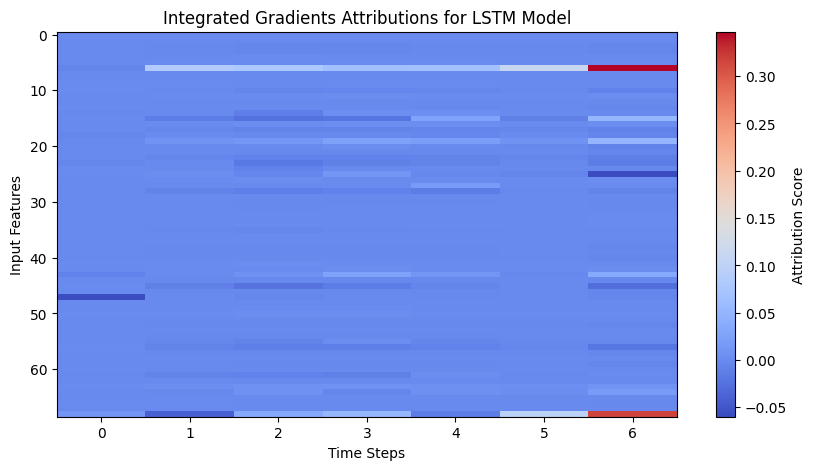

In [ ]:
ig = IntegratedGradients(best_model.to('cpu'))
input_data = X_torch[0:1].to('cpu')
feature_data = fea_torch[0:1].to('cpu')

# Compute the attributions (SHAP-like values)
attributions, delta = ig.attribute(inputs=(input_data, feature_data), target=0, return_convergence_delta=True)

# Visualize the attributions for the input sequence
attributions = attributions[0].cpu().detach().numpy()

# Plot the attributions across time steps and features
plt.figure(figsize=(10, 5))
plt.imshow(attributions[0].T, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Attribution Score')
plt.xlabel('Time Steps')
plt.ylabel('Input Features')
plt.title('Integrated Gradients Attributions for LSTM Model')
plt.show()

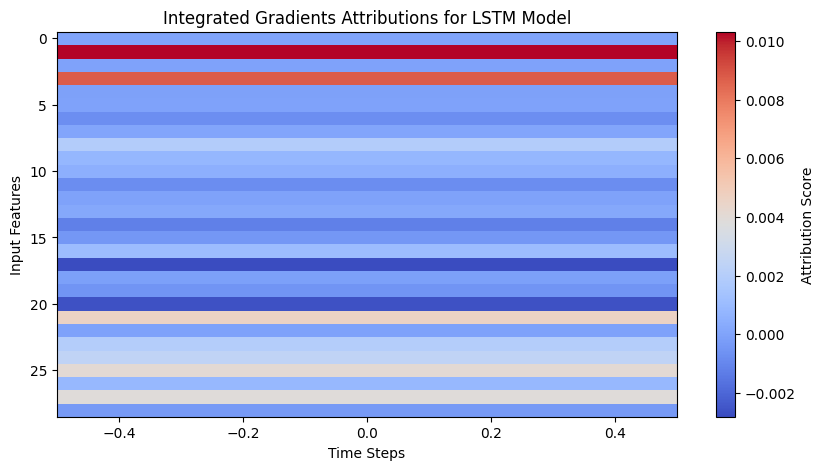

In [ ]:
ig = IntegratedGradients(best_model.to('cpu'))
input_data = X_torch[0:1].to('cpu')
feature_data = fea_torch[0:1].to('cpu')

# Compute the attributions (SHAP-like values)
attributions, delta = ig.attribute(inputs=(input_data, feature_data), target=0, return_convergence_delta=True)

# Visualize the attributions for the input sequence
fea = attributions[1].T
attributions = attributions[1].cpu().detach().numpy()

# Plot the attributions across time steps and features
plt.figure(figsize=(10, 5))
plt.imshow(fea, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Attribution Score')
plt.xlabel('Time Steps')
plt.ylabel('Input Features')
plt.title('Integrated Gradients Attributions for LSTM Model')
plt.show()

### Predict Non-Active

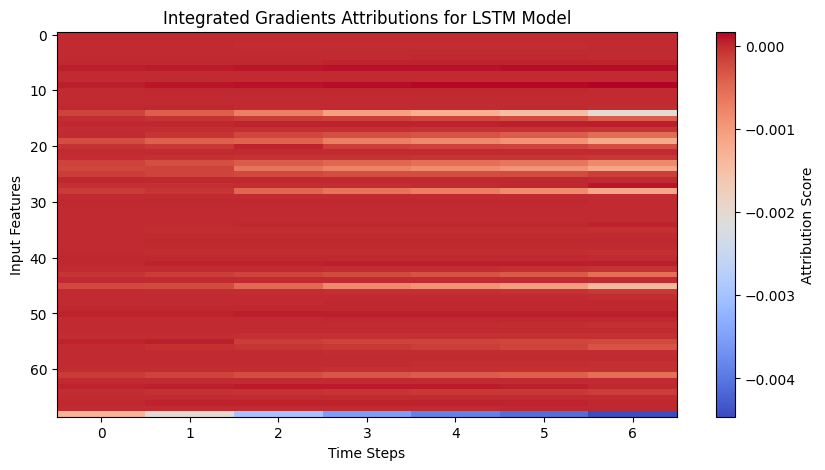

In [ ]:
ig = IntegratedGradients(best_model.to('cpu'))
input_data = X_torch[9:10].to('cpu')
feature_data = fea_torch[9:10].to('cpu')

# Compute the attributions (SHAP-like values)
attributions, delta = ig.attribute(inputs=(input_data, feature_data), target=0, return_convergence_delta=True)

# Visualize the attributions for the input sequence
attributions = attributions[0].cpu().detach().numpy()

# Plot the attributions across time steps and features
plt.figure(figsize=(10, 5))
plt.imshow(attributions[0].T, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Attribution Score')
plt.xlabel('Time Steps')
plt.ylabel('Input Features')
plt.title('Integrated Gradients Attributions for LSTM Model')
plt.show()

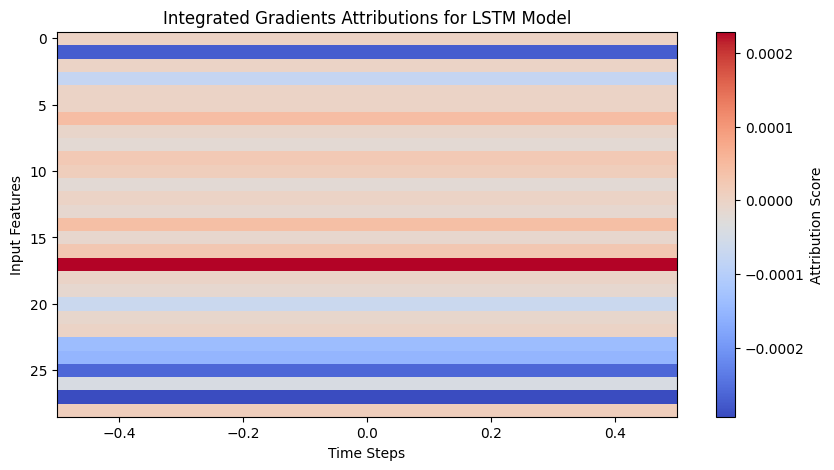

In [ ]:
ig = IntegratedGradients(best_model.to('cpu'))
input_data = X_torch[9:10].to('cpu')
feature_data = fea_torch[9:10].to('cpu')

# Compute the attributions (SHAP-like values)
attributions, delta = ig.attribute(inputs=(input_data, feature_data), target=0, return_convergence_delta=True)

# Visualize the attributions for the input sequence
fea = attributions[1].T
attributions = attributions[1].cpu().detach().numpy()

# Plot the attributions across time steps and features
plt.figure(figsize=(10, 5))
plt.imshow(fea, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Attribution Score')
plt.xlabel('Time Steps')
plt.ylabel('Input Features')
plt.title('Integrated Gradients Attributions for LSTM Model')
plt.show()

#### Analysis

In [ ]:
# analysis use
X_torch = torch.from_numpy(X_30d_minmaxscaler).float()
y_torch = torch.from_numpy(y_30d_minmaxscaler).float().unsqueeze(-1)
fea_torch = torch.from_numpy(user_df_minmaxscaler).float()

In [ ]:
with torch.no_grad():
    y_test_list = []
    output_list = []
    y_pred_list = []
    for seq, labels, feature in zip(X_torch, y_torch, fea_torch):
        seq, labels, feature = seq.to(device).float(), labels.to(device).float(), feature.to(device).float()
        y_pred = best_model(seq.unsqueeze(0), feature.unsqueeze(0))
        output = y_pred
        y_pred = (y_pred > 0.43).float() # Final Version 0.45, first 4 months & label 7th month 0.43, first 5 months & label 7th month 0.41

        y_test_list.append(labels.squeeze().tolist())
        output_list.append(output.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())

target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.78      0.59      0.67     10425
      Active       0.91      0.96      0.93     45429

    accuracy                           0.89     55854
   macro avg       0.84      0.77      0.80     55854
weighted avg       0.89      0.89      0.89     55854



In [ ]:
user_orig_df = pd.read_csv('/home/jupyter/lstm/temp_table/df_bool_30day_first4mon_orig.csv')

In [ ]:
static_feature_analysis = user_orig_df.copy()

In [ ]:
static_feature_analysis['y_prob'] = output_list
static_feature_analysis['y_pred'] = y_pred_list
static_feature_analysis['y_label'] = y_test_list

In [ ]:
static_feature_analysis = static_feature_analysis.sort_values(by=['y_prob'], ascending=False).reset_index(drop=True)
user_length = static_feature_analysis.shape[0]//10 + 1

static_feature_analysis['h_score'] = 'low'
static_feature_analysis.loc[static_feature_analysis.iloc[(user_length)*3:(user_length)*7-2].index, 'h_score'] = 'middle'
static_feature_analysis.loc[static_feature_analysis.iloc[(user_length)*7-2:].index, 'h_score'] = 'high'

In [ ]:
def grouping_column(_feature_score, column, interval):
    
    _feature_score[column] = ''
    range_num = int(1/interval)
    
    for i in range(range_num, 0, -1):
        
        if i % 10 == 1:
            value = str(i) + 'st'
        elif i % 10 == 2:
            value = str(i) + 'nd'
        elif i % 10 == 3:
            value = str(i) + 'rd'
        else:
            value = str(i) + 'th'
 
        if i == int(1/interval):
            _feature_score.loc[0:len(_feature_score), column] = value
        elif i == 1:
            _feature_score.loc[int(len(_feature_score)*interval*(range_num-i))+1:len(_feature_score), column] = value
        else:
            _feature_score.loc[int(len(_feature_score)*interval*(range_num-i))+1:int(len(_feature_score)*interval*(range_num+1-i)), column] = value
    return _feature_score

In [ ]:
static_feature_analysis = static_feature_analysis.sort_values(by=['y_prob'], ascending=True).reset_index(drop=True)
static_feature_analysis['Non_active'] = static_feature_analysis['y_label'].map({0:1, 1:0})

static_feature_analysis = grouping_column(static_feature_analysis, 'h_score_10', 0.1)
static_feature_analysis = grouping_column(static_feature_analysis, 'h_score_20', 0.05)
static_feature_analysis

In [ ]:
def plt_grouping(_feature_score, y_test, level, plt_title):
 
    active = _feature_score.groupby([level, 'Non_active']).nunique().reset_index()[[level, 'Non_active', 'hashed_sn']]
    active = active.merge(_feature_score.groupby([level]).nunique().reset_index()[[level, 'hashed_sn']], on=level, suffixes=('_nonactive', '_all'))
    active['Non_active_rate'] = 100*active['hashed_sn_nonactive']/active['hashed_sn_all']
    active = active.sort_values(by=['Non_active_rate'], ascending=False)
    
    df_plt = active[active['Non_active']==1].sort_values(by=['Non_active_rate'], ascending=True)
    test_active_rate = 100*float(y_test.value_counts()[1]) / y_test.shape[0]
    plt.figure(figsize=(10,6))
    bar = plt.bar(df_plt[level], df_plt['Non_active_rate'], alpha=0.5)#, width=0.5
    plt.axhline(y=test_active_rate, linewidth=3, color='r', label='Overall Non-Active Rate')
    plt.text(-0.24, test_active_rate+2, f'{test_active_rate:.1f}%', va='center', ha='center', color='r', fontsize=12)
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=12)
 
    plt.ylabel('Non-Active Rate(%)')
    plt.xlabel('Hibernating Score Category')
    plt.ylim(0,105)
    plt.legend(loc=2)
    plt.title(f'Non-Active Rate of Each Hibernating Score Category {plt_title}')
    plt.show()

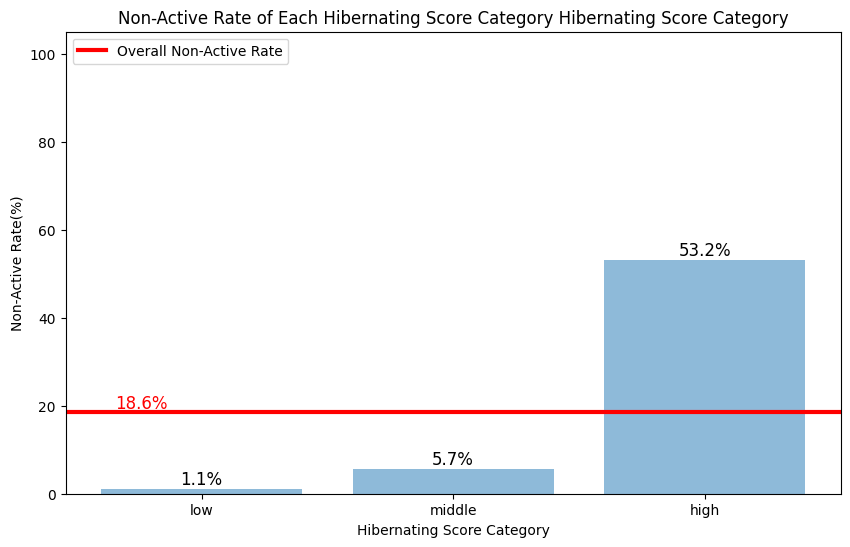

In [ ]:
y_test = static_feature_analysis['Non_active']
plt_grouping(static_feature_analysis, y_test, 'h_score', 'Hibernating Score Category')

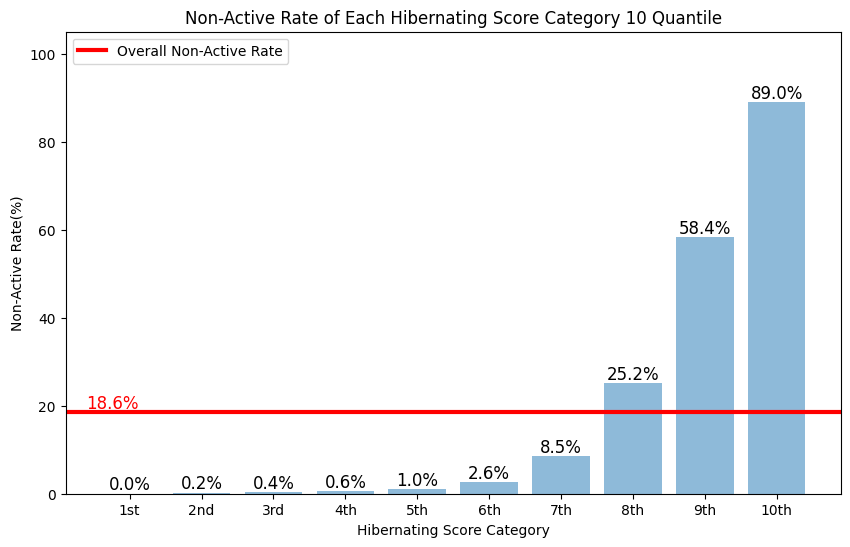

In [ ]:
plt_grouping(static_feature_analysis, y_test, 'h_score_10', '10 Quantile')

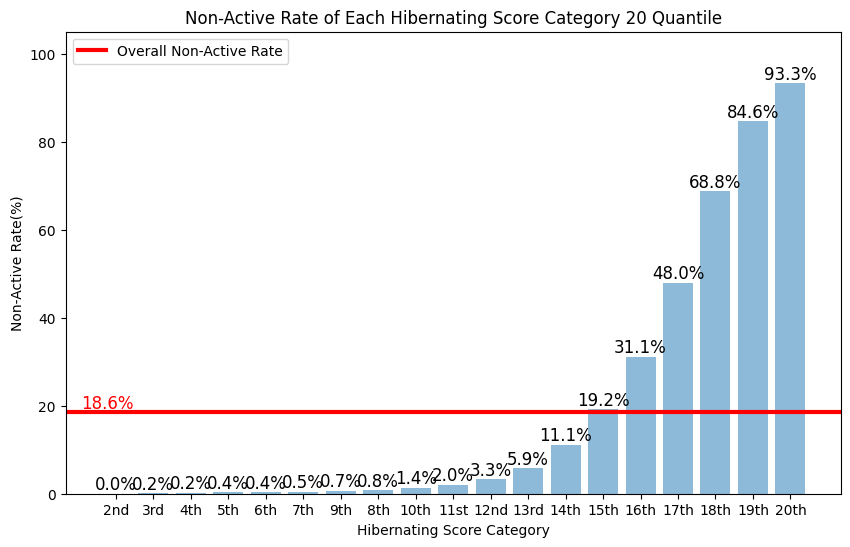

In [ ]:
plt_grouping(static_feature_analysis, y_test, 'h_score_20', '20 Quantile')

##### Feature Distribution

In [ ]:
static_feature_high = static_feature_analysis[static_feature_analysis['h_score']=='high']
static_feature_mid = static_feature_analysis[static_feature_analysis['h_score']=='middle']
static_feature_low = static_feature_analysis[static_feature_analysis['h_score']=='low']

In [ ]:
from matplotlib.ticker import PercentFormatter

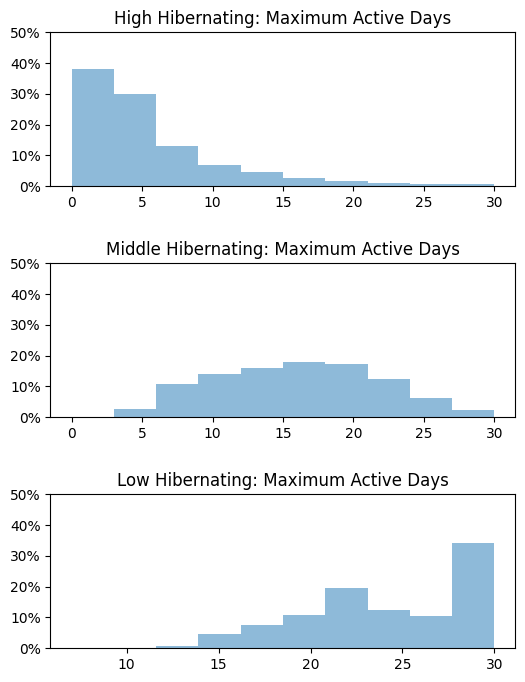

In [ ]:
plt.figure(figsize=(6, 8))

plt.subplot(311)
plt.hist(static_feature_high['ec_max'], weights=np.ones(len(static_feature_high)) / len(static_feature_high), alpha=0.5)
plt.ylim((0, 0.5))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('High Hibernating: Maximum Active Days')

plt.subplot(312)
plt.hist(static_feature_mid['ec_max'], weights=np.ones(len(static_feature_mid)) / len(static_feature_mid), alpha=0.5)
plt.ylim((0, 0.5))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Middle Hibernating: Maximum Active Days')

plt.subplot(313)
plt.hist(static_feature_low['ec_max'], weights=np.ones(len(static_feature_low)) / len(static_feature_low), alpha=0.5)
plt.ylim((0, 0.5))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Low Hibernating: Maximum Active Days')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

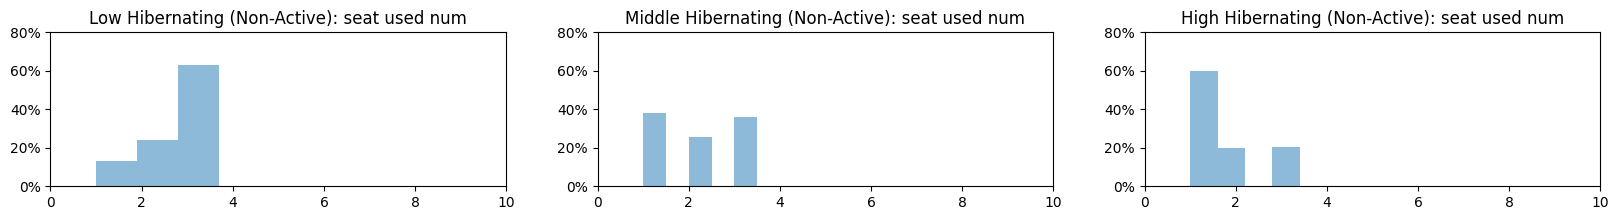

In [ ]:
plt.figure(figsize=(20, 2))

plt.subplot(133)
plt.hist(static_feature_high['license_seat_used_number_x'], weights=np.ones(len(static_feature_high)) / len(static_feature_high), alpha=0.5)
plt.ylim((0, 0.8))
plt.xlim((0, 10))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('High Hibernating (Non-Active): seat used num')

plt.subplot(132)
plt.hist(static_feature_mid['license_seat_used_number_x'], weights=np.ones(len(static_feature_mid)) / len(static_feature_mid), alpha=0.5)
plt.ylim((0, 0.8))
plt.xlim((0, 10))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Middle Hibernating (Non-Active): seat used num')

plt.subplot(131)
plt.hist(static_feature_low['license_seat_used_number_x'], weights=np.ones(len(static_feature_low)) / len(static_feature_low), alpha=0.5)
plt.ylim((0, 0.8))
plt.xlim((0, 10))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Low Hibernating (Non-Active): seat used num')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

Text(0.5, 1.0, 'Using Data Theft Protection % of Each Hibernating Score Category')

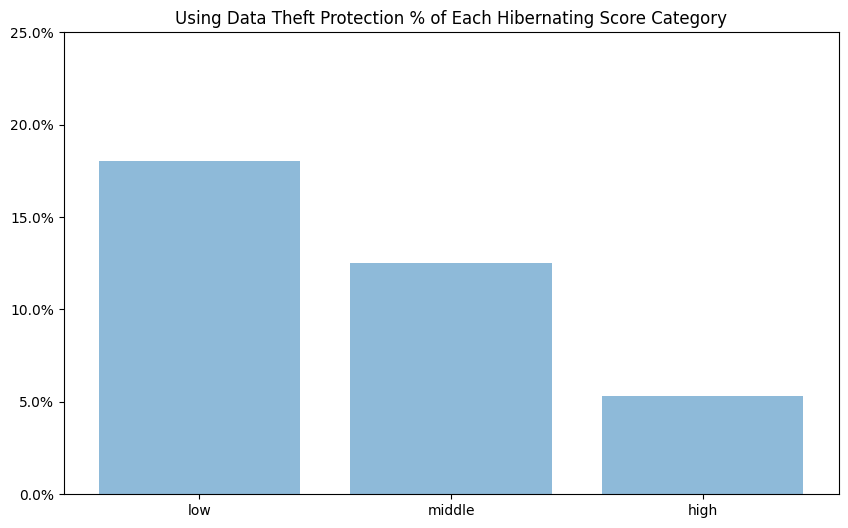

In [ ]:
dtp_plt = static_feature_analysis.groupby(['h_score', 'event_dtp']).nunique().reset_index()[['h_score', 'event_dtp', 'hashed_sn']]
dtp_plt = dtp_plt.merge(static_feature_analysis.groupby(['h_score']).nunique().reset_index()[['h_score', 'hashed_sn']], on='h_score', suffixes=('_dtp', '_all'))
dtp_plt['dtp'] = dtp_plt['hashed_sn_dtp']/dtp_plt['hashed_sn_all']
dtp_plt = dtp_plt.sort_values(by=['dtp'], ascending=False)
dtp_plt = dtp_plt[dtp_plt['event_dtp']==1].sort_values(by=['dtp'], ascending=True)

plt.figure(figsize=(10, 6))
plt.bar(dtp_plt['h_score'], dtp_plt['dtp'], alpha=0.5)
plt.gca().invert_xaxis()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylim(0, 0.25)
plt.title('Using Data Theft Protection % of Each Hibernating Score Category', size=12)

Text(0.5, 1.0, 'Enable Toolbar % of Each Hibernating Score Category')

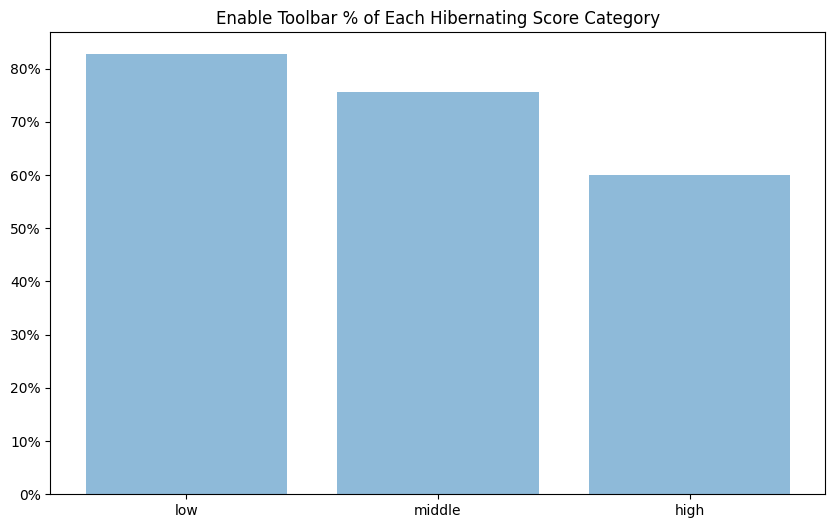

In [ ]:
toolbar_plt = static_feature_analysis.groupby(['h_score', 'event_toolbar_enable']).nunique().reset_index()[['h_score', 'event_toolbar_enable', 'hashed_sn']]
toolbar_plt = toolbar_plt.merge(static_feature_analysis.groupby(['h_score']).nunique().reset_index()[['h_score', 'hashed_sn']], on='h_score', suffixes=('_toolbar', '_all'))
toolbar_plt['toolbar'] = toolbar_plt['hashed_sn_toolbar']/toolbar_plt['hashed_sn_all']
toolbar_plt = toolbar_plt.sort_values(by=['toolbar'], ascending=False)
toolbar_plt = toolbar_plt[toolbar_plt['event_toolbar_enable']==1].sort_values(by=['toolbar'], ascending=True)

plt.figure(figsize=(10, 6))
plt.bar(toolbar_plt['h_score'], toolbar_plt['toolbar'], alpha=0.5)
plt.gca().invert_xaxis()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.ylim(0, 0.25)
plt.title('Enable Toolbar % of Each Hibernating Score Category', size=12)

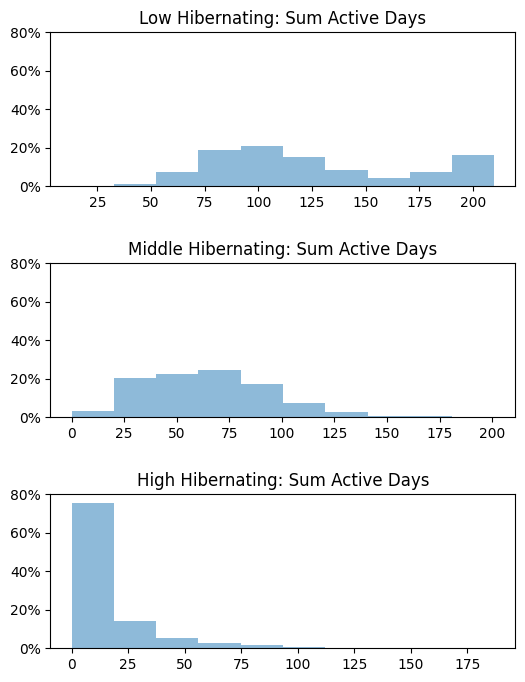

In [ ]:
plt.figure(figsize=(6, 8))

plt.subplot(311)
plt.hist(static_feature_high['ec_sum'], weights=np.ones(len(static_feature_high)) / len(static_feature_high), alpha=0.5)
plt.ylim((0, 0.8))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Low Hibernating: Sum Active Days')

plt.subplot(312)
plt.hist(static_feature_mid['ec_sum'], weights=np.ones(len(static_feature_mid)) / len(static_feature_mid), alpha=0.5)
plt.ylim((0, 0.8))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Middle Hibernating: Sum Active Days')

plt.subplot(313)
plt.hist(static_feature_low['ec_sum'], weights=np.ones(len(static_feature_low)) / len(static_feature_low), alpha=0.5)
plt.ylim((0, 0.8))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('High Hibernating: Sum Active Days')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

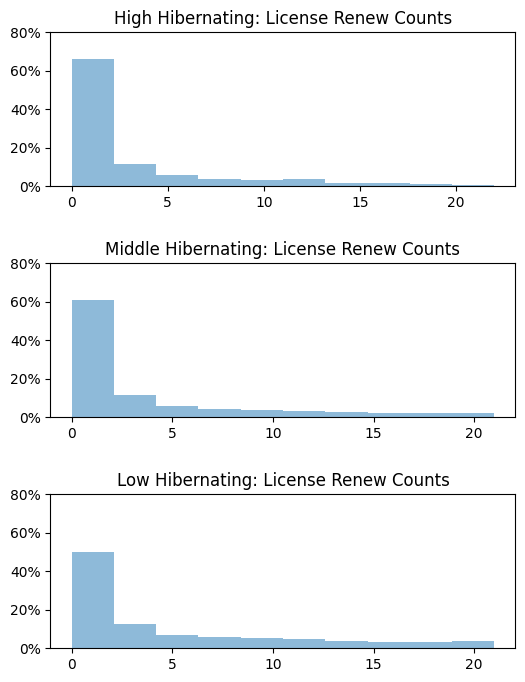

In [ ]:
plt.figure(figsize=(6, 8))

plt.subplot(311)
plt.hist(static_feature_high['license_renew_count_x'], weights=np.ones(len(static_feature_high)) / len(static_feature_high), alpha=0.5)
plt.ylim((0, 0.8))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('High Hibernating: License Renew Counts')

plt.subplot(312)
plt.hist(static_feature_mid['license_renew_count_x'], weights=np.ones(len(static_feature_mid)) / len(static_feature_mid), alpha=0.5)
plt.ylim((0, 0.8))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Middle Hibernating: License Renew Counts')

plt.subplot(313)
plt.hist(static_feature_low['license_renew_count_x'], weights=np.ones(len(static_feature_low)) / len(static_feature_low), alpha=0.5)
plt.ylim((0, 0.8))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Low Hibernating: License Renew Counts')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

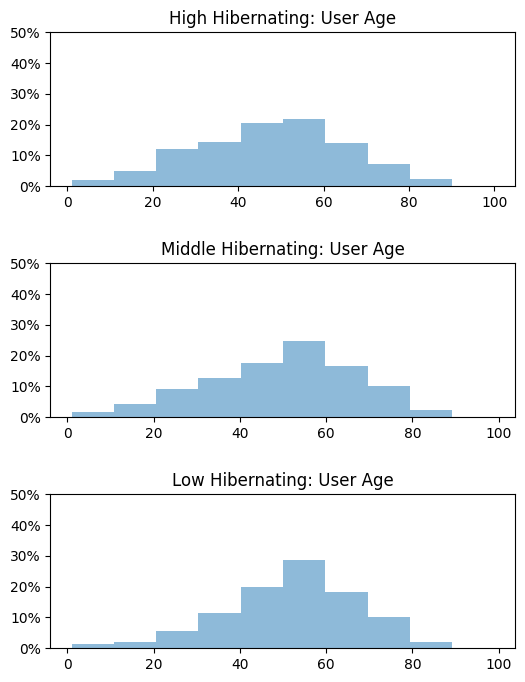

In [ ]:
plt.figure(figsize=(6, 8))

plt.subplot(311)
plt.hist(static_feature_high['age'], weights=np.ones(len(static_feature_high)) / len(static_feature_high), alpha=0.5)
plt.ylim((0, 0.5))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('High Hibernating: User Age')

plt.subplot(312)
plt.hist(static_feature_mid['age'], weights=np.ones(len(static_feature_mid)) / len(static_feature_mid), alpha=0.5)
plt.ylim((0, 0.5))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Middle Hibernating: User Age')

plt.subplot(313)
plt.hist(static_feature_low['age'], weights=np.ones(len(static_feature_low)) / len(static_feature_low), alpha=0.5)
plt.ylim((0, 0.5))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Low Hibernating: User Age')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

In [ ]:
data_30d = data_30d[data_30d['hashed_sn'].isin(static_feature_analysis['hashed_sn'])]

In [ ]:
data_30d = data_30d.merge(static_feature_analysis[['hashed_sn', 'h_score']], how='left', on='hashed_sn')

In [ ]:
month = [i for i in range(1, 9, 1)]*(static_feature_analysis['hashed_sn'].nunique())
data_30d['month'] = month

In [ ]:
dynamic_feature_high = data_30d[data_30d['h_score']=='high']
dynamic_feature_mid = data_30d[data_30d['h_score']=='middle']
dynamic_feature_low = data_30d[data_30d['h_score']=='low']

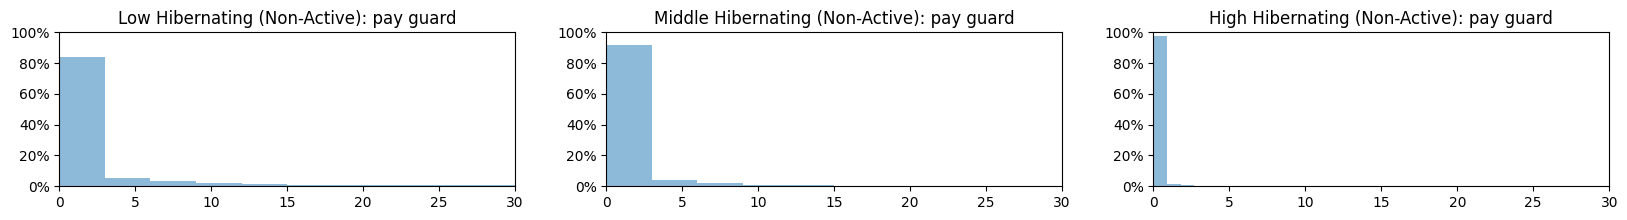

In [ ]:
plt.figure(figsize=(20, 2))

plt.subplot(133)
plt.hist(dynamic_feature_high[dynamic_feature_high['month']==7]['event_pay_guard']
         , weights=np.ones(len(dynamic_feature_high[dynamic_feature_high['month']==7])) / len(dynamic_feature_high[dynamic_feature_high['month']==7]), alpha=0.5)
plt.ylim((0, 1))
plt.xlim((0, 30))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('High Hibernating (Non-Active): pay guard')

plt.subplot(132)
plt.hist(dynamic_feature_mid[dynamic_feature_mid['month']==7]['event_pay_guard']
         , weights=np.ones(len(dynamic_feature_mid[dynamic_feature_mid['month']==7])) / len(dynamic_feature_mid[dynamic_feature_mid['month']==7]), alpha=0.5)
plt.ylim((0, 1))
plt.xlim((0, 30))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Middle Hibernating (Non-Active): pay guard')

plt.subplot(131)
plt.hist(dynamic_feature_low[dynamic_feature_low['month']==7]['event_pay_guard']
         , weights=np.ones(len(dynamic_feature_low[dynamic_feature_low['month']==7])) / len(dynamic_feature_low[dynamic_feature_low['month']==7]), alpha=0.5)
plt.ylim((0, 1))
plt.xlim((0, 30))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Low Hibernating (Non-Active): pay guard')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

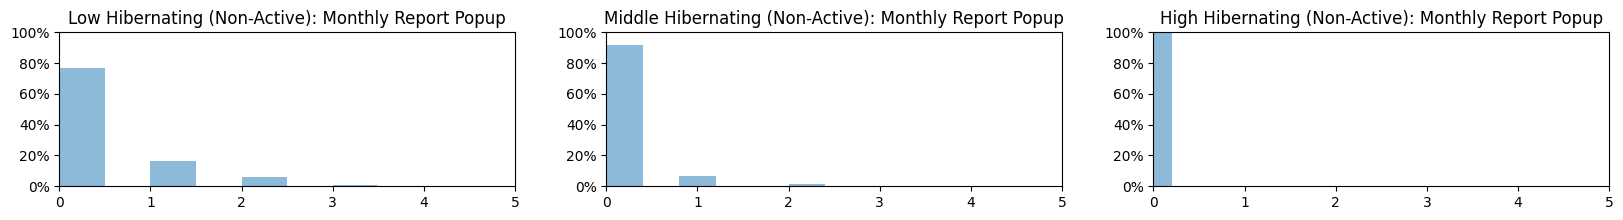

In [ ]:
plt.figure(figsize=(20, 2))

plt.subplot(133)
plt.hist(dynamic_feature_high[dynamic_feature_high['month']==7]['event_OpenMonthlyReportPopup']
         , weights=np.ones(len(dynamic_feature_high[dynamic_feature_high['month']==7])) / len(dynamic_feature_high[dynamic_feature_high['month']==7]), alpha=0.5)
plt.ylim((0, 1))
plt.xlim((0, 5))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('High Hibernating (Non-Active): Monthly Report Popup')

plt.subplot(132)
plt.hist(dynamic_feature_mid[dynamic_feature_mid['month']==7]['event_OpenMonthlyReportPopup']
         , weights=np.ones(len(dynamic_feature_mid[dynamic_feature_mid['month']==7])) / len(dynamic_feature_mid[dynamic_feature_mid['month']==7]), alpha=0.5)
plt.ylim((0, 1))
plt.xlim((0, 5))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Middle Hibernating (Non-Active): Monthly Report Popup')

plt.subplot(131)
plt.hist(dynamic_feature_low[dynamic_feature_low['month']==7]['event_OpenMonthlyReportPopup']
         , weights=np.ones(len(dynamic_feature_low[dynamic_feature_low['month']==7])) / len(dynamic_feature_low[dynamic_feature_low['month']==7]), alpha=0.5)
plt.ylim((0, 1))
plt.xlim((0, 5))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Low Hibernating (Non-Active): Monthly Report Popup')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)